In [1]:
# Project ideas

# Use PINN and Fourier networks to solve
# - PINN: Evaluate optimal PINN architectures 
# - FN : Evaluate optimal FN architectures
# Benchmark against analytical solutions
# Compare and contrast -> conclusion

In [3]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt
from pyDOE import lhs
from matplotlib.path import Path
import matplotlib.tri as tri

# Boundaries

In [6]:
# ------------------------
# Define D-Shaped Boundary 
# ------------------------
tau = torch.linspace(0, 2*np.pi, 1000)
epsilon = 0.32
kappa = 1.70
delta = 0.33

R_bdy = 1 + epsilon * torch.cos(tau + np.arcsin(delta) * torch.sin(tau)) 
Z_bdy = epsilon * kappa * torch.sin(tau)
X_b = torch.stack([R_bdy, Z_bdy], dim=1)

# ------------------------
# Collocation Points Inside D-Shape using LHS
# ------------------------
N_f = 10000
R0, R1 = R_bdy.min().item(), R_bdy.max().item()
Z0, Z1 = Z_bdy.min().item(), Z_bdy.max().item()

lhs_samples = lhs(2, samples=N_f)
R_rand = R0 + (R1 - R0) * lhs_samples[:, 0]
Z_rand = Z0 + (Z1 - Z0) * lhs_samples[:, 1]
X_all = np.vstack([R_rand, Z_rand]).T

boundary_polygon = Path(X_b.numpy())
mask = boundary_polygon.contains_points(X_all)
X_f = torch.tensor(X_all[mask], dtype=torch.float32)

# ------------------------
# PDE Constant P
# ------------------------

A = -0.155
C = 1 - A
R0 = 1.0  # normalized major radius

P_const = (C * R0**2) / (A + C * R0**2)

# Analytical Solution

In [9]:
import sympy as sp

# ---------------------------------------------
# Define symbols
# ---------------------------------------------
R, Z = sp.symbols('R Z')
c1, c2, c3, c4, c5, c6, c7 = sp.symbols('c1 c2 c3 c4 c5 c6 c7')
P, epsilon, kappa, delta, alpha = sp.symbols('P epsilon kappa delta alpha')

# ---------------------------------------------
# Define phi_H and phi_total (symbolic)
# ---------------------------------------------
phi_H = (P * R**4)/8 + (1 - P) * ((R**2)/2) * sp.log(P)

phi_1 = 1
phi_2 = R**2
phi_3 = Z**2 - (R**2) * sp.log(R)
phi_4 = R**4 - 4 * (R**2) * (Z**2)
phi_5 = 2 * Z**4 - 9 * (R**2) * (Z**2) + 3 * (R**4) * sp.log(R) - 12 * (R**2) * (Z**2) * sp.log(R)
phi_6 = R**6 - 12 * (R**4) * (Z**2) + 8 * (R**2) * (Z**4)
phi_7 = (8 * Z**6 - 140 * Z**4 * R**2 + 75 * Z**2 * R**4 
         - 15 * R**6 * sp.log(R) + 180 * R**4 * Z**2 * sp.log(R) - 120 * R**2 * Z**4 * sp.log(R))

phi_total = phi_H + phi_1*c1 + phi_2*c2 + phi_3*c3 + phi_4*c4 + phi_5*c5 + phi_6*c6 + phi_7*c7

# ---------------------------------------------
# Define derivatives
# ---------------------------------------------
dphi_dR = sp.diff(phi_total, R)
dphi_RR = sp.diff(dphi_dR, R)

dphi_dZ = sp.diff(phi_total, Z)
dphi_ZZ = sp.diff(dphi_dZ, Z)

# ---------------------------------------------
# Define constants for substitutions
# ---------------------------------------------
# Assign actual numerical values for testing

A = -0.155
C = 1 - A
R0 = 1.0  # normalized major radius

P_val = (C * R0**2) / (A + C * R0**2)

epsilon_val = 0.32
kappa_val = 1.70
delta_val = 0.33
alpha_val = np.arcsin(delta_val)

subs_dict = {
    P: P_val,
    epsilon: epsilon_val,
    kappa: kappa_val,
    delta: delta_val,
    alpha: alpha_val
}

# ---------------------------------------------
# Derivative-related coefficients
# ---------------------------------------------
N1 = -((1 + alpha_val)**2) / (epsilon_val * kappa_val**2)
N2 = ((1 - alpha_val)**2) / (epsilon_val * kappa_val**2)
N3 = -kappa_val / (epsilon_val * (np.cos(alpha_val))**2)

# ---------------------------------------------
# Define 7 equations by substitution
# ---------------------------------------------
eq1 = sp.Eq(phi_total.subs(subs_dict).subs({R: 1 + epsilon_val, Z: 0}), 0)
eq2 = sp.Eq(phi_total.subs(subs_dict).subs({R: 1 - epsilon_val, Z: 0}), 0)
eq3 = sp.Eq(phi_total.subs(subs_dict).subs({R: 1 + delta_val * epsilon_val, Z: kappa_val * epsilon_val}), 0)

eq4 = sp.Eq(dphi_dR.subs(subs_dict).subs({R: 1 - delta_val * epsilon_val, Z: kappa_val * epsilon_val}), 0)
eq5 = sp.Eq(dphi_ZZ.subs(subs_dict).subs({R: 1 + epsilon_val, Z: 0}),
            -N1 * dphi_dR.subs(subs_dict).subs({R: 1 + epsilon_val, Z: 0}))
eq6 = sp.Eq(dphi_ZZ.subs(subs_dict).subs({R: 1 - epsilon_val, Z: 0}),
            -N2 * dphi_dR.subs(subs_dict).subs({R: 1 - epsilon_val, Z: 0}))
eq7 = sp.Eq(dphi_RR.subs(subs_dict).subs({R: 1 - delta_val * epsilon_val, Z: kappa_val * epsilon_val}),
            -N3 * dphi_dZ.subs(subs_dict).subs({R: 1 - delta_val * epsilon_val, Z: kappa_val * epsilon_val}))

# ---------------------------------------------
# Solve the system
# ---------------------------------------------
solution = sp.solve([eq1, eq2, eq3, eq4, eq5, eq6, eq7], (c1, c2, c3, c4, c5, c6, c7))

# Print solution
print("System solution:")
for k, v in solution.items():
    print(f"{k} = {v.evalf()}")

System solution:
c1 = 0.0491252251869467
c2 = -1.20026772523622
c3 = 0.919325612644571
c4 = 0.440723358834193
c5 = -0.634614815656486
c6 = 0.531835955970237
c7 = 0.0217235930698908


In [11]:
# Convert to NumPy for evaluation
R_bdy_np = R_bdy.numpy()
Z_bdy_np = Z_bdy.numpy()

# ---- Assuming all symbolic parts are defined: phi_H, phi_1 to phi_7, and solution ---- #

# Extracting the constants from the symbolic solution
c_1 = float(solution[c1])
c_2 = float(solution[c2])
c_3 = float(solution[c3])
c_4 = float(solution[c4])
c_5 = float(solution[c5])
c_6 = float(solution[c6])
c_7 = float(solution[c7])

# Symbolic expression for phi
phi_sol_num = (
    phi_H + phi_1*c_1 + phi_2*c_2 + phi_3*c_3 +
    phi_4*c_4 + phi_5*c_5 + phi_6*c_6 + phi_7*c_7
)

P = sp.symbols('P')

phi_sol_num = phi_sol_num.subs({P: P_val})

In [13]:
#Lambdify the final solution
R_sym, Z_sym = sp.symbols("R Z")
phi_func = sp.lambdify((R_sym, Z_sym), phi_sol_num, modules="numpy")

# Create D-shaped boundary
tau = np.linspace(0, 2 * np.pi, 1000)
epsilon = 0.32
kappa = 1.70
delta = 0.33
alpha = np.arcsin(delta)

R_bdy = 1 + epsilon * np.cos(tau + alpha * np.sin(tau))
Z_bdy = epsilon * kappa * np.sin(tau)

# Define plotting grid
n_test = 300
R0_plot, R1_plot = R_bdy.min(), R_bdy.max()
Z0_plot, Z1_plot = Z_bdy.min(), Z_bdy.max()

r_test = np.linspace(R0_plot, R1_plot, n_test)
z_test = np.linspace(Z0_plot, Z1_plot, n_test)
R_grid, Z_grid = np.meshgrid(r_test, z_test, indexing='ij')

# Flatten for evaluation
R_flat = R_grid.flatten()
Z_flat = Z_grid.flatten()
X_test = np.column_stack((R_flat, Z_flat))

# Filter to inside boundary
boundary_polygon = Path(np.column_stack((R_bdy, Z_bdy)))
mask = boundary_polygon.contains_points(X_test)
X_inside = X_test[mask]
R_inside = X_inside[:, 0]
Z_inside = X_inside[:, 1]

# Evaluate the function
phi_vals = phi_func(R_inside, Z_inside)
phi_vals = np.array(phi_vals, dtype=np.float64)

In [15]:
phi_vals.shape

(69188,)

In [17]:
R_inside.shape

(69188,)

In [19]:
# Hard Boundary constraint function
def G(R,Z):
    T1 = np.abs(Z)
    T2 = np.arccos((np.abs(R) - 1)/epsilon) - (np.arcsin(delta))*((np.abs(Z))/(epsilon*kappa))
    return T1 - epsilon*kappa*T2

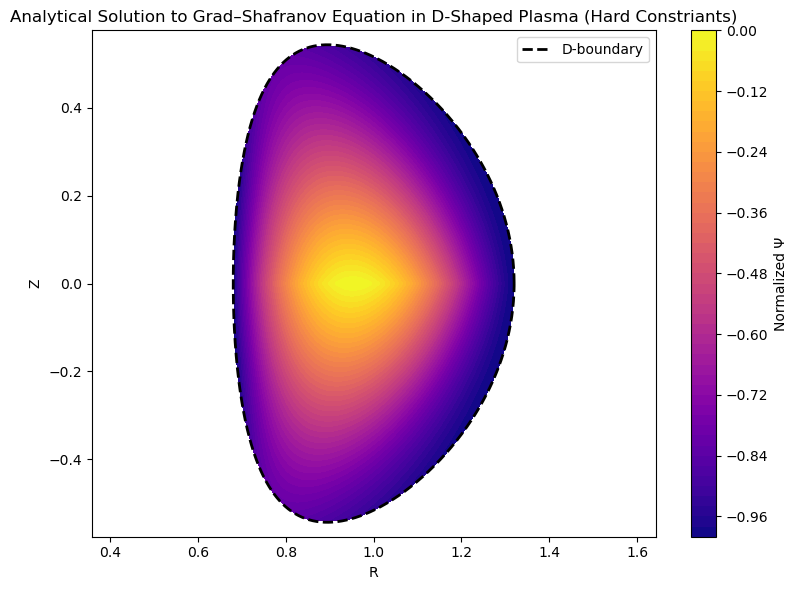

In [21]:
# --------------------
# Plotting the results
# --------------------

phi_vals = G(R_inside, Z_inside) * phi_vals

# Normalize for plotting
phi_vals = (phi_vals - np.max(phi_vals)) / (np.max(phi_vals) - np.min(phi_vals))

# Plot with triangulation
triang = tri.Triangulation(R_inside, Z_inside)

plt.figure(figsize=(8, 6))
cf = plt.tricontourf(triang, phi_vals, levels=50, cmap='plasma')
plt.plot(R_bdy, Z_bdy, 'k--', linewidth=2, label='D-boundary')
plt.colorbar(cf, label='Normalized Ψ')
plt.xlabel("R")
plt.ylabel("Z")
plt.title("Analytical Solution to Grad–Shafranov Equation in D-Shaped Plasma (Hard Constriants)")
plt.axis("equal")
plt.legend()
plt.tight_layout()
plt.show()

# PINN solution

In [24]:
# ------------------------
# 1. PINN Model
# ------------------------

class GS_PINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.activation = nn.Tanh()
        self.linears = nn.ModuleList([
            nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)
        ])
        for L in self.linears:
            nn.init.xavier_normal_(L.weight, gain=nn.init.calculate_gain('tanh'))
            nn.init.zeros_(L.bias)

    def forward(self, x):
        for L in self.linears[:-1]:
            x = self.activation(L(x))
        return self.linears[-1](x)

    def pde_residual(self, x, P_const):
        x = x.clone().requires_grad_(True)
        psi = self.forward(x)

        grads = autograd.grad(psi, x, torch.ones_like(psi), create_graph=True)[0]
        dpsi_dR = grads[:, 0:1]
        dpsi_dZ = grads[:, 1:2]

        d2psi_dR2 = autograd.grad(dpsi_dR, x, torch.ones_like(dpsi_dR), create_graph=True)[0][:, 0:1]
        d2psi_dZ2 = autograd.grad(dpsi_dZ, x, torch.ones_like(dpsi_dZ), create_graph=True)[0][:, 1:2]

        R = x[:, 0:1]

        # Normalized Grad–Shafranov residual:
        res = d2psi_dR2 - (1.0 / R) * dpsi_dR + d2psi_dZ2 - P_const * R**2 - (1 - P_const)
        return res

    def loss(self, X_f, X_b, P_const, weight_pde=1.0, weight_b=1.0):
        res = self.pde_residual(X_f, P_const)
        loss_pde = torch.mean(res**2)
        psi_b = self.forward(X_b)
        loss_b = torch.mean(psi_b**2)

        return weight_pde * loss_pde + weight_b * loss_b

# PINN BOUNDARY

In [27]:
# ------------------------
# Define D-Shaped Boundary
# ------------------------
tau = torch.linspace(0, 2*np.pi, 1000)
epsilon = 0.32
kappa = 1.70
delta = 0.33

R_bdy = 1 + epsilon * torch.cos(tau + np.arcsin(delta) * torch.sin(tau)) 
Z_bdy = epsilon * kappa * torch.sin(tau)
X_b = torch.stack([R_bdy, Z_bdy], dim=1)

# ------------------------
# Collocation Points Inside D-Shape using LHS
# ------------------------
N_f = 10000
R0, R1 = R_bdy.min().item(), R_bdy.max().item()
Z0, Z1 = Z_bdy.min().item(), Z_bdy.max().item()

lhs_samples = lhs(2, samples=N_f)
R_rand = R0 + (R1 - R0) * lhs_samples[:, 0]
Z_rand = Z0 + (Z1 - Z0) * lhs_samples[:, 1]
X_all = np.vstack([R_rand, Z_rand]).T

boundary_polygon = Path(X_b.numpy())
mask = boundary_polygon.contains_points(X_all)
X_f = torch.tensor(X_all[mask], dtype=torch.float32)

# ------------------------
# PDE Constant P
# ------------------------

A = -0.155
C = 1 - A
R0 = 1.0  # normalized major radius

P_const = (C * R0**2) / (A + C * R0**2)

# PINN Trianing

In [30]:
# ------------------------
# Initialize and Train
# ------------------------

from torch.optim.lr_scheduler import StepLR

model = GS_PINN(layers=[2, 64, 64, 1])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = StepLR(optimizer, step_size=1000, gamma=0.8)  

for epoch in range(8000):
    optimizer.zero_grad()
    loss = model.loss(X_f, X_b, P_const)
    loss.backward()
    optimizer.step()
    scheduler.step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss = {loss.item():.3e}")

Epoch 0, Loss = 1.317e+01
Epoch 500, Loss = 1.213e-02
Epoch 1000, Loss = 4.404e-03
Epoch 1500, Loss = 7.316e-04
Epoch 2000, Loss = 6.487e-05
Epoch 2500, Loss = 2.217e-05
Epoch 3000, Loss = 1.184e-04
Epoch 3500, Loss = 1.092e-05
Epoch 4000, Loss = 1.058e-05
Epoch 4500, Loss = 8.690e-06
Epoch 5000, Loss = 1.265e-05
Epoch 5500, Loss = 8.505e-06
Epoch 6000, Loss = 8.686e-06
Epoch 6500, Loss = 7.661e-06
Epoch 7000, Loss = 1.664e-05
Epoch 7500, Loss = 7.721e-06


In [32]:
# Use full R_bdy and Z_bdy ranges for visualization
R0_plot, R1_plot = R_bdy.min().item(), R_bdy.max().item()
Z0_plot, Z1_plot = Z_bdy.min().item(), Z_bdy.max().item()

n_test = 300
r_test = torch.linspace(R0_plot, R1_plot, n_test)
z_test = torch.linspace(Z0_plot, Z1_plot, n_test)
R_test, Z_test = torch.meshgrid(r_test, z_test, indexing='ij')
X_test = torch.hstack((R_test.reshape(-1, 1), Z_test.reshape(-1, 1)))

# Filter points inside the boundary
boundary_polygon = Path(X_b.numpy())
mask = boundary_polygon.contains_points(X_test.numpy())
X_interior = X_test[mask]

# Predict
with torch.no_grad():
    psi_pred = model(X_interior).squeeze().numpy()

R_test = R_test.reshape(-1,1)
Z_test = Z_test.reshape(-1,1)

R_test = R_test.cpu().detach().numpy()
Z_test = Z_test.cpu().detach().numpy()

G_prime = G(R_test, Z_test)

print(G_prime.shape)
print(psi_pred.shape)

# Imposing Hard Constraint on solution
phi_pred = G(R_test, Z_test) * psi_pred

(90000, 1)
(69188,)


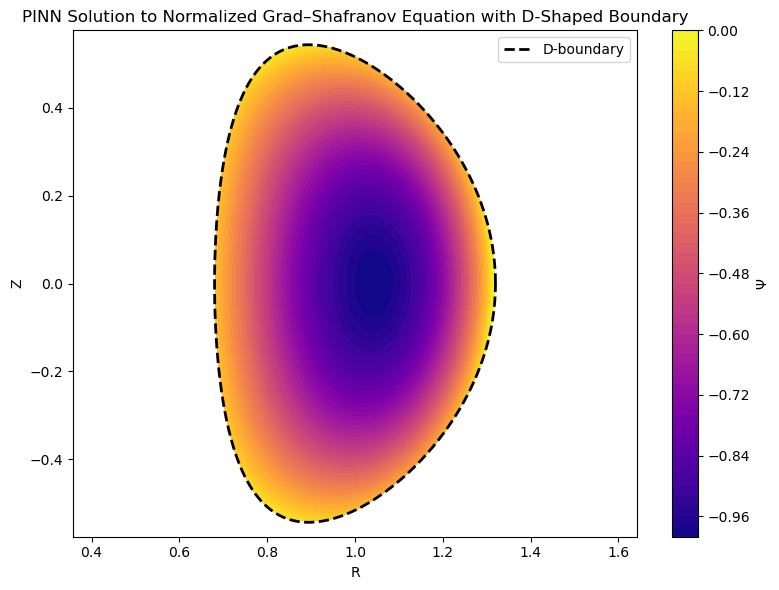

In [34]:
# Normalize prediction
psi_pred = (psi_pred - np.max(psi_pred)) / (np.max(psi_pred) - np.min(psi_pred))

# Plot using triangulation
triang = tri.Triangulation(X_interior[:, 0], X_interior[:, 1])

plt.figure(figsize=(8, 6))
cf = plt.tricontourf(triang, psi_pred, levels=50, cmap='plasma')
plt.plot(R_bdy.numpy(), Z_bdy.numpy(), 'k--', linewidth=2, label='D-boundary')
plt.colorbar(cf, label='Ψ')
plt.xlabel("R")
plt.ylabel("Z")
plt.title("PINN Solution to Normalized Grad–Shafranov Equation with D-Shaped Boundary")
plt.axis("equal")
plt.legend()
plt.tight_layout()
plt.show()

# Plot of Collocation Points Via Latin HyperCube Sampling

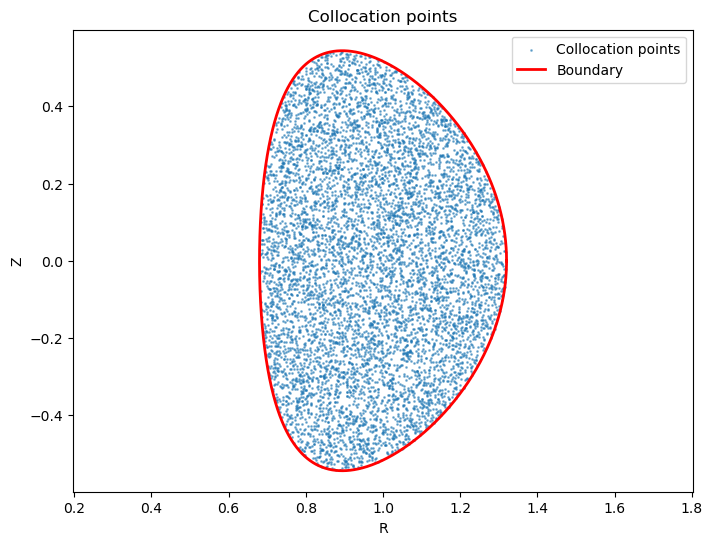

In [37]:
plt.figure(figsize=(8, 6))
plt.scatter(X_f[:, 0], X_f[:, 1], s=1, alpha=0.5, label='Collocation points')
plt.plot(R_bdy.numpy(), Z_bdy.numpy(), 'r-', linewidth=2, label='Boundary')
plt.axis('equal')
plt.ylabel("Z")
plt.xlabel("R")
plt.title("Collocation points")
plt.legend()
plt.show()

# Comparison between Analytical and PINN solution

In [40]:
loss = np.mean((psi_pred - phi_vals)**2)
print("Total MSE loss: ", loss)

loss_point = np.abs(psi_pred - phi_vals)

Total MSE loss:  0.24190991220024796


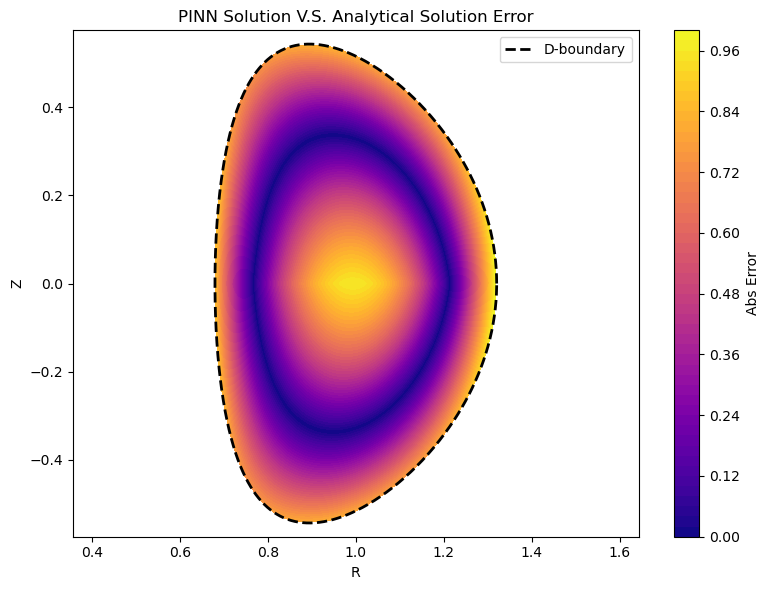

In [42]:
plt.figure(figsize=(8, 6))
cf = plt.tricontourf(triang, loss_point, levels=50, cmap='plasma')
plt.plot(R_bdy.numpy(), Z_bdy.numpy(), 'k--', linewidth=2, label='D-boundary')
plt.colorbar(cf, label='Abs Error')
plt.xlabel("R")
plt.ylabel("Z")
plt.title("PINN Solution V.S. Analytical Solution Error")
plt.axis("equal")
plt.legend()
plt.tight_layout()
plt.show()